mark

In [1]:
from tf_helper import *

2022-10-03 13:08:43.286670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 13:08:43.376270: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-03 13:08:43.724618: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2022-10-03 13:08:43.724660: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [2]:
# import os
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
# # os.environ['TF_GPU_ALLOCATOR']

In [3]:
N = 56

input_shape = (N, N, 1)#datasets_info.features['image'].shape
encoded_size = 16
base_depth = 32

from xrdc import fourier

In [4]:
def mk_rand():
    return int(128 * np.random.uniform())

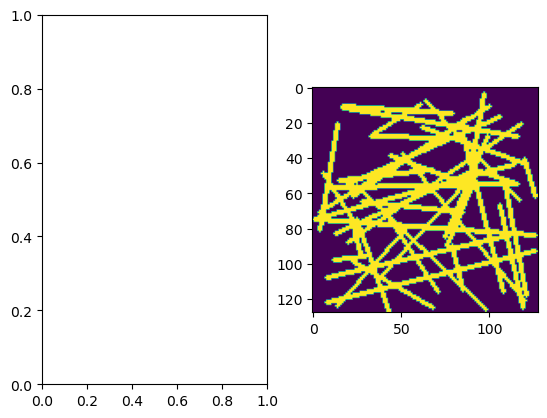

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import draw, morphology

def mk_lines_img():
    image = np.zeros((128, 128))
    for _ in range(40):
        rr, cc = draw.line(mk_rand(), mk_rand(), mk_rand(), mk_rand())
        image[rr, cc] = 1
    dilated = morphology.dilation(image, morphology.disk(radius=1))
    res = np.zeros((128, 128, 3))
    res[:, :, :] = dilated[..., None]
    return res
fig, (ax0, ax1) = plt.subplots(1, 2)
# ax0.imshow(image)
ax1.imshow(mk_lines_img()[..., 1])

In [2]:
from tensorflow.signal import fft

from tensorflow.keras.layers import Lambda
from tensorflow.signal import fft, fft2d, fftshift, ifft2d, ifft2d

import tensorflow as tf

# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp


tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

# # from skimage.transform import resize

# from xrdc.source_separation import *
# from skimage.transform import resize as sresize
# from tensorflow.signal import fft2d, fftshift

    



# @tf.function
# def get_mask(input):
#     import tensorflow as tf
#     mask = tf.where(input > support_threshold, tf.ones_like(input),
#                     tf.zeros_like(input))
#     return mask

# @tf.function
# def add_support(input):
#     mask = get_mask(input)
#     return input * tf.cast(mask, tf.float32)

# def resize(x):
#     rmod = do_resize()
#     rmod.compile(loss = 'mse')
#     return rmod.predict(x)

2022-10-04 14:59:34.961760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-04 14:59:35.042537: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-04 14:59:35.393743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2022-10-04 14:59:35.393782: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [11]:
(tfd.Independent(tfd.Poisson(100 * tf.ones(10)))).sample()

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 92., 109.,  94., 105.,  99., 114.,  85., 111.,  88., 111.],
      dtype=float32)>

In [7]:
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
tf.config.experimental.get_memory_usage('GPU:0')

Instructions for updating:
Use tf.config.experimental.get_memory_info(device)['current'] instead.


Instructions for updating:
Use tf.config.experimental.get_memory_info(device)['current'] instead.
2022-10-03 13:08:48.242675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 13:08:48.243871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 13:08:48.244136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-03 13:08:48.244345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

0

In [9]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
from xrdc import fourier

In [11]:
sys_details = tf.sysconfig.get_build_info()
cuda_version = sys_details["cuda_version"]
print(cuda_version)

11.2


In [12]:
cudnn_version = sys_details["cudnn_version"]  
print(cudnn_version)

8


In [13]:
padx = pady = N // 2
# def do_resize():
#     #padx = pady = x.shape[1] // 2
#     transform = tfkl.AveragePooling2D(2)
#     return tfk.Sequential([
#         tfk.Input(shape = (N, N, 1)),
#         transform
#     ])

filt = fourier.lowpass_g(.6, np.ones(N))
probe = gf(((np.einsum('i,j->ij', filt, filt)) > .5).astype(float), 2)
tprobe = (tf.convert_to_tensor(probe, tf.float32)[..., None])

In [12]:
ds_lines = {'train':  tf.data.Dataset.from_tensor_slices([tf.convert_to_tensor(mk_lines_img()) for _ in range(500)])}
ds = ds_lines

In [14]:
def do_forward(sequential = None):
    """
    zero-pad the real-space object and then fourier transform it
    """
    if sequential is None:
        sequential = tfk.Sequential([])
        
    #padder = tfkl.ZeroPadding2D((padx // 2, padx // 2))

    #sequential.add(padder)
    sequential.add(tfk.Input(shape = (N, N, 1)))
    sequential.add(Lambda(lambda resized: (fft2d(
        tf.squeeze(tf.cast(resized, tf.complex64))
    ))))
    sequential.add(Lambda(lambda X: tf.math.real(tf.math.conj(X) * X) / N**2))
    sequential.add(Lambda(lambda psd: 
                          tf.expand_dims(
                              tf.math.sqrt(
            fftshift(psd, (-2, -1))), 3)))
    #sequential.add(Lambda(lambda x: tf.math.log(1 + 5 * x)),)
    return sequential

rmod = do_forward()
rmod.compile(loss='mse')

def split_image(image3, tile_size):
    n, m =  image3.shape[0], image3.shape[1]
    N, M = (n // tile_size[0]) * tile_size[0], (m // tile_size[1]) * tile_size[1]
    image3 = image3[:N, :M, :]
    image_shape = tf.shape(image3)
    tile_rows = tf.reshape(image3, [image_shape[0], -1, tile_size[1], image_shape[2]])
    serial_tiles = tf.transpose(tile_rows, [1, 0, 2, 3])
    return tf.reshape(serial_tiles, [-1, tile_size[1], tile_size[0], image_shape[2]])


def split_tf_image(img):
    return tf.compat.v1.extract_image_patches(img[None, ...], [1, N, N, 1], [1, N // 4, N // 4, 1],
                                              [1, 1, 1, 1], padding = 'VALID')

def img_get(key, ds):
    for img in iter(ds[key]):
        yield split_tf_image(img)

def img_get(key, ds):
    foo = iter(ds[key])
    for i, img in enumerate(foo):
        if i > 5000:
            break
        yield split_tf_image(img['image'])
#     foo =  iter(datasets2[key])
#     for _ in range(3):
#         yield split_tf_image(next(foo))

def mk_ds_slices(key, ds):
    tmp = list(img_get(key, ds))
    tmp = tf.concat(tmp, 0)
    tmp = tf.reshape(tmp, [-1, N, N, 3])[:, :, :, 0]
    tmp2 = tf.data.Dataset.from_tensor_slices(tmp)
    return tmp2


datasets2, datasets_info2 = tfds.load(name='coil100',
                                    with_info=True,
                                    as_supervised=False)
def _preprocess(sample):
    image = tf.cast(sample, 
                    tf.float32) / 255.  # Scale to unit interval.
    orig = tf.identity(image)
    print(tprobe.shape, image.shape)
    image = image[..., None] * tprobe
    print(tprobe.shape, image.shape)

    orig_probe = tf.identity(image)
    rmod = do_forward()
    rmod.compile(loss='mse')
    print(image.shape)
    image = rmod(image)#rmod.predict(image)
    return image, image, orig_probe#, orig

ds = mk_ds_slices('train', datasets2)

DATASET_SIZE = len(ds)
train_size = int(0.8 * DATASET_SIZE)
# val_size = int(0.4 * DATASET_SIZE)
test_size = int(0.2 * DATASET_SIZE)

full_dataset = ds#tf.data.TFRecordDataset(FLAGS.input_file)
# full_dataset = full_dataset.shuffle(int(10e3))
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

train_dataset = (train_dataset
                 .batch(128)
                 .map(_preprocess)
                 .cache()
                 .prefetch(tf.data.AUTOTUNE)
                 .shuffle(int(10e3))
                )


eval_dataset = (test_dataset
                .batch(128)
                .map(_preprocess)
                .cache()
                .prefetch(tf.data.AUTOTUNE))

2022-10-03 13:10:15.454563: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(56, 56, 1) (None, 56, 56)
(56, 56, 1) (None, 56, 56, 1)
(None, 56, 56, 1)
(56, 56, 1) (None, 56, 56)
(56, 56, 1) (None, 56, 56, 1)
(None, 56, 56, 1)


In [15]:
it = iter(eval_dataset)

In [16]:
xx = next(it)

In [17]:
x = xx[2][:10]

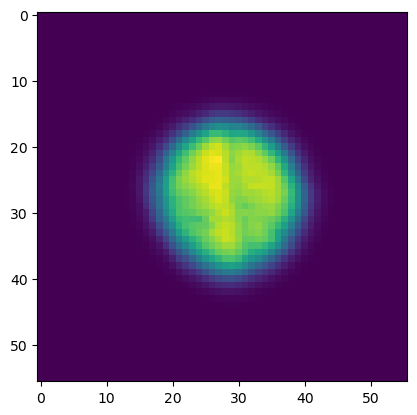

In [18]:
plt.imshow((.1 + np.array(x).squeeze()[3]))

In [19]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
                        reinterpreted_batch_ndims=1)

In [33]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    tf.keras.layers.BatchNormalization(),
    tfkl.Conv2D(base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=1,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(2 * base_depth, 5, strides=2,
                padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Flatten(),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
               activation=None),
    tfpl.MultivariateNormalTriL(
        encoded_size,
        #activity_regularizer=tfpl.KLDivergenceRegularizer(prior)
    ),
])


In [34]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Reshape([1, 1, encoded_size]),
    tf.keras.layers.BatchNormalization(),
    tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                         padding='valid', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    
    tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                         padding='same', activation=tf.nn.leaky_relu),
    tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                         padding='same', activation=tf.nn.leaky_relu),
    

    tf.keras.layers.BatchNormalization(),
#     tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
#                 padding='same', activation=None),
    tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                padding='same', activation=tf.nn.sigmoid),
    
     tfkl.Reshape((input_shape)),
#    tfkl.Reshape((input_shape[0] // 2, input_shape[1] // 2, 1)),

##     Lambda(lambda x: tf.clip_by_value(x, 0, 1))

    # impose real space support
#     Lambda(lambda x: add_support(x),
#                     name='masked_obj')
    
])

support_threshold = .0


decoder2 = tfk.Sequential([
    tfkl.InputLayer(input_shape = tf.TensorShape([None, None, None])),
    Lambda(lambda x: tprobe * x),
    Lambda(lambda x: add_support(x),
            name='masked_obj'),
    do_forward(),
    #tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc = t, scale = 0.0015))),
    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc = t, scale = 0.005))),
])


In [35]:
# vae = tfk.Model(inputs=encoder.inputs,
#                 outputs=decoder(encoder.outputs[0]))

vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder2(decoder(encoder.outputs[0])))

In [51]:
for layer in encoder.layers:
    print(layer.name, layer.output_shape)
    
for layer in decoder.layers:
    print(layer.name, layer.output_shape)

lambda_13 (None, 56, 56, 1)
batch_normalization_6 (None, 56, 56, 1)
conv2d_12 (None, 56, 56, 32)
conv2d_13 (None, 28, 28, 32)
conv2d_14 (None, 28, 28, 64)
conv2d_15 (None, 14, 14, 64)
conv2d_16 (None, 8, 8, 64)
flatten_2 (None, 4096)
dense_2 (None, 152)
multivariate_normal_tri_l_1 ((None, 16), (None, 16))
reshape_4 (None, 1, 1, 16)
batch_normalization_7 (None, 1, 1, 16)
conv2d_transpose_16 (None, 7, 7, 64)
conv2d_transpose_17 (None, 7, 7, 64)
conv2d_transpose_18 (None, 14, 14, 64)
conv2d_transpose_19 (None, 14, 14, 32)
conv2d_transpose_20 (None, 28, 28, 32)
conv2d_transpose_21 (None, 28, 28, 32)
conv2d_transpose_22 (None, 56, 56, 32)
conv2d_transpose_23 (None, 56, 56, 32)
batch_normalization_8 (None, 56, 56, 32)
conv2d_17 (None, 56, 56, 1)
reshape_5 (None, 56, 56, 1)


In [37]:
for layer in decoder2.layers:
    print(layer.name, layer.output_shape)

lambda_14 (None, 56, 56, None)
masked_obj (None, 56, 56, None)
sequential_11 None
distribution_lambda_2 (None, None)


In [44]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
            loss=negloglik)

In [47]:
_ = vae.fit(train_dataset,
            epochs=1,
            validation_data=eval_dataset)

1126/1126 [==============================] - ETA: 0s - loss: 1128.1434WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


1126/1126 [==============================] - 44s 39ms/step - loss: 1128.1434 - val_loss: 878.0867


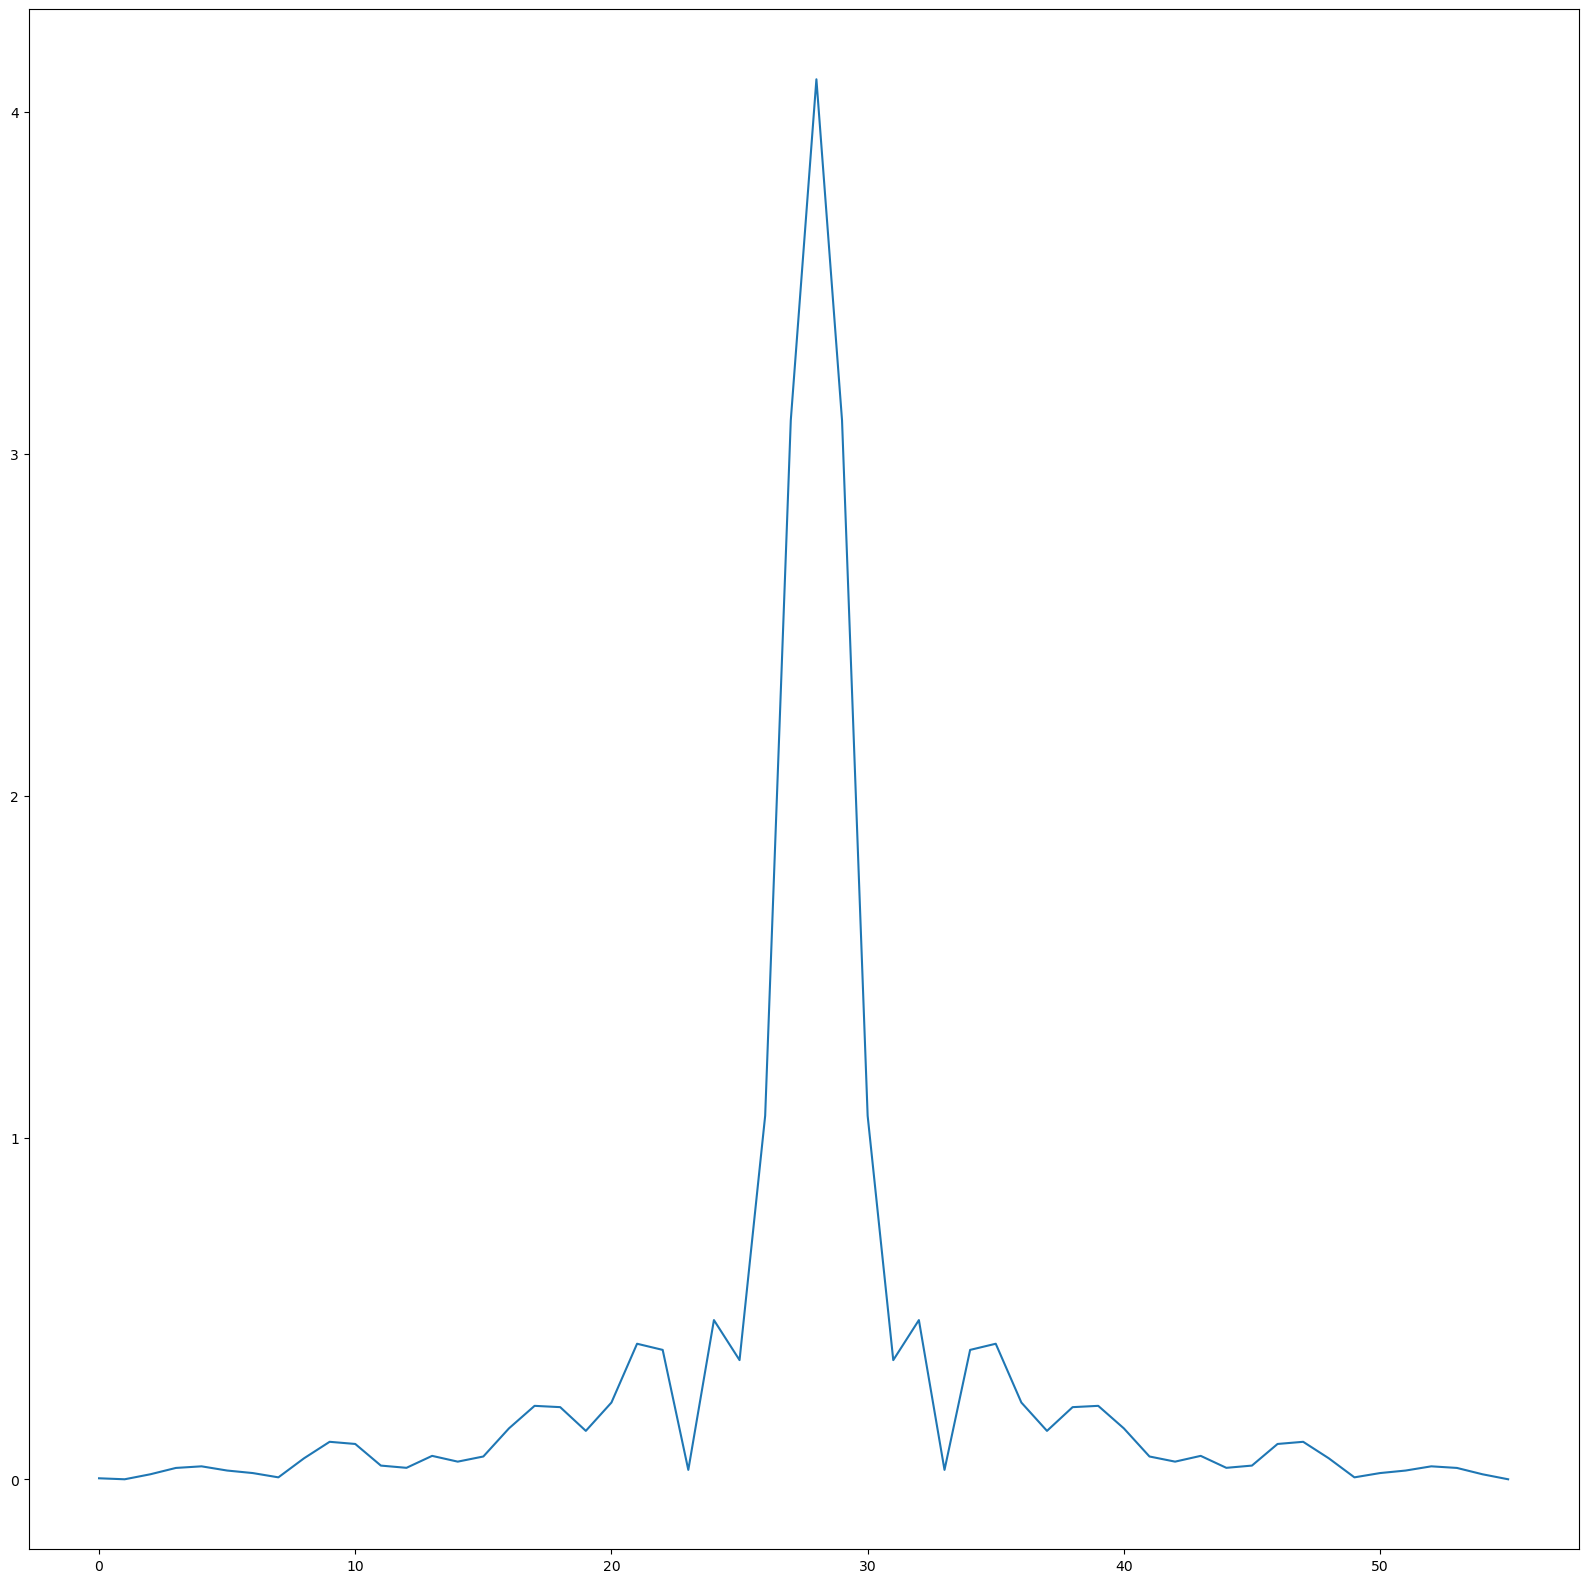

In [66]:
plt.plot(np.squeeze(x)[-2][28, :])

In [34]:
np.percentile(x, 2)

0.015548927243798971

In [18]:
# !pip install pydot

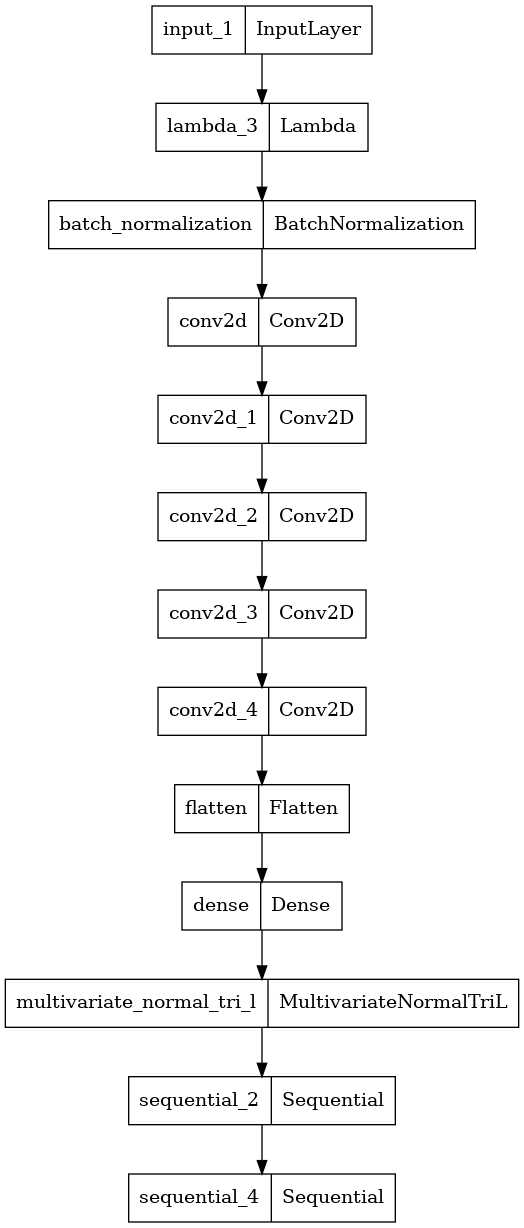

In [23]:
tf.keras.utils.plot_model(vae, 'foo.png')

In [40]:
import matplotlib.pyplot as plt

def display_imgs(x, y=None, log = False, cbar = False):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  #plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 2))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    if log:
        axs.flat[i].imshow(np.log(.01 + x[i].squeeze()), interpolation='none', cmap='jet')
    else:
        axs.flat[i].imshow((x[i].squeeze()), interpolation='none', cmap='jet')
    axs.flat[i].axis('off')
  if cbar:
    plt.colorbar()
  plt.show()
  plt.close()
  plt.ion()

In [111]:
# plt.hist(np.array(tf.squeeze(x[5])).ravel());

In [67]:
# plt.imshow(np.array((decoder(encoder(x)))).squeeze()[4], cmap = 'jet')

# plt.imshow(np.array(resize((x_orig))).squeeze()[2], cmap = 'jet')

# plt.imshow(np.array(resize(decoder(encoder(x)))).squeeze()[2], cmap = 'jet')

In [68]:
# plt.imshow(np.array(decoder2(decoder(encoder(x))).mean()).squeeze()[0], cmap = 'jet')

In [45]:
from xrdc import fourier

In [51]:
np.mean(x), np.mean(x_orig), np.mean(xhat.mode())

(0.3511565, 0.075934604, 0.33525014)

In [57]:
np.percentile(x, 50)

0.13848519325256348

Input diffraction:


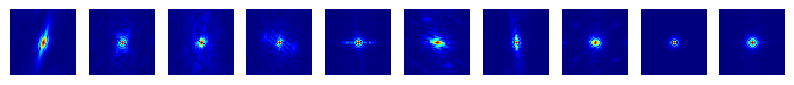

Reconstructed diffraction (modes):


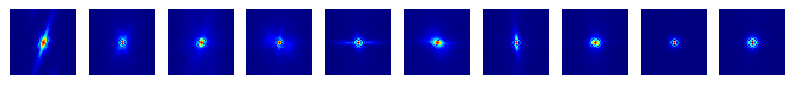

True object


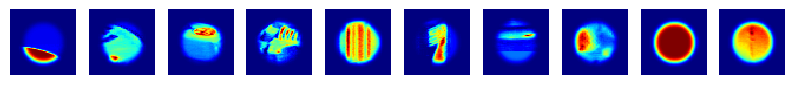

Reconstructed object (mode)


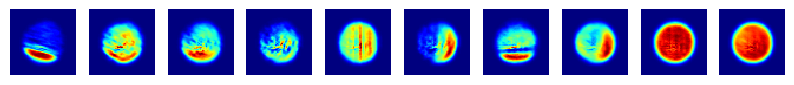

Reconstructed object variance


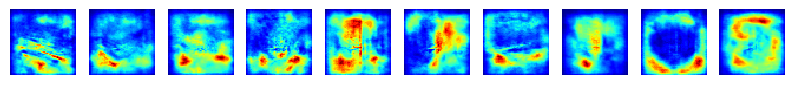

Reconstructed diffraction variance


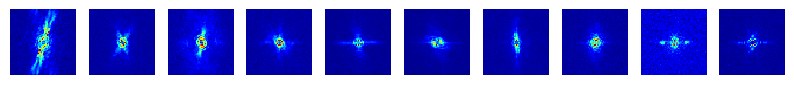

0.038710432585329746

In [18]:
x_orig = next(iter(eval_dataset))[2][:10]
# x_orig = next(iter(eval_dataset))[2][10:20]

# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
# x = next(iter(eval_dataset))[0][10:20]

# x_orig = next(iter(eval_dataset))[2][10:20]

# # We'll just examine ten random digits.
# x = next(iter(eval_dataset))[0][10:20]

xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] =(20, 20)

print('Input diffraction:')
display_imgs(x)

# print('Decoded Random Samples (top: reconstruction; bottom: diffraction):')
# tmp = decoder(encoder(x))
# display_imgs(tmp)
# display_imgs(decoder2(tmp).sample())

print('Reconstructed diffraction (modes):')
display_imgs(xhat.mode())

# print('Decoded Means:')
# display_imgs(xhat.mean())

print("True object")
display_imgs((x_orig))

print("Reconstructed object (mode)")
display_imgs((tprobe * decoder(encoder(x).mean())))

print('Reconstructed object variance')
tmp = tf.stack([decoder(encoder(x)) for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))

print('Reconstructed diffraction variance')
tmp = tf.stack([vae(x).sample() for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))


# display_imgs(tf.abs(decoder(encoder(x).mode()) - resize(x_orig)))

np.percentile(np.array(tmp).std(axis = 0).ravel(), 99.9)



Input diffraction:


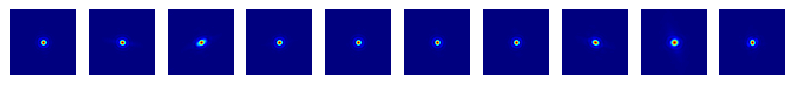

Reconstructed diffraction (modes):


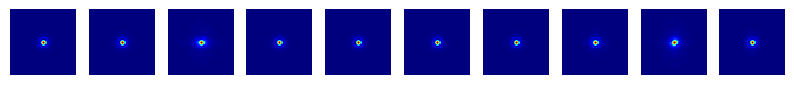

True object


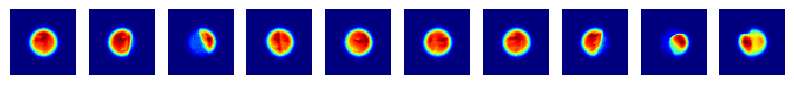

Reconstructed object (mode)


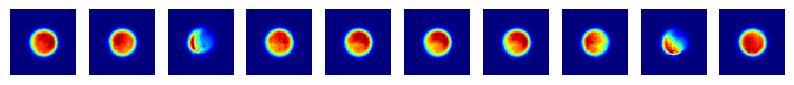

Reconstructed object variance


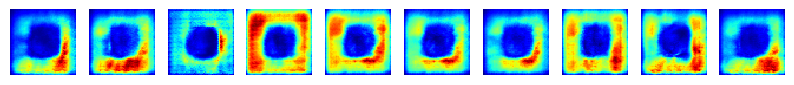

Reconstructed diffraction variance


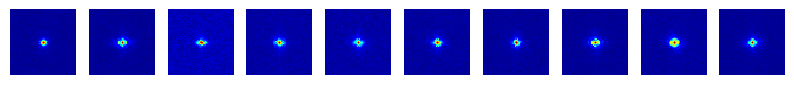

0.04053827886283481

In [46]:
x_orig = next(iter(eval_dataset))[2][:10]
# x_orig = next(iter(eval_dataset))[2][10:20]

# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
# x = next(iter(eval_dataset))[0][10:20]

# x_orig = next(iter(eval_dataset))[2][10:20]

# # We'll just examine ten random digits.
# x = next(iter(eval_dataset))[0][10:20]

xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] =(20, 20)

print('Input diffraction:')
display_imgs(x)

# print('Decoded Random Samples (top: reconstruction; bottom: diffraction):')
# tmp = decoder(encoder(x))
# display_imgs(tmp)
# display_imgs(decoder2(tmp).sample())

print('Reconstructed diffraction (modes):')
display_imgs(xhat.mode())

# print('Decoded Means:')
# display_imgs(xhat.mean())

print("True object")
display_imgs((x_orig))

print("Reconstructed object (mode)")
display_imgs((tprobe * decoder(encoder(x).mean())))

print('Reconstructed object variance')
tmp = tf.stack([decoder(encoder(x)) for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))

print('Reconstructed diffraction variance')
tmp = tf.stack([vae(x).sample() for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))


# display_imgs(tf.abs(decoder(encoder(x).mode()) - resize(x_orig)))

np.percentile(np.array(tmp).std(axis = 0).ravel(), 99.9)



In [35]:
dilated.shape

(128, 128)

In [47]:
np.array(mpimg.imread('ePIE_recon_simulation/fruit.jpg')).max()

255

probe not 3d. OK
Scanning positions defined
Diffraction patterns created
Iteration 1 starts
Iteration 2 starts
Iteration 3 starts
End of iterations


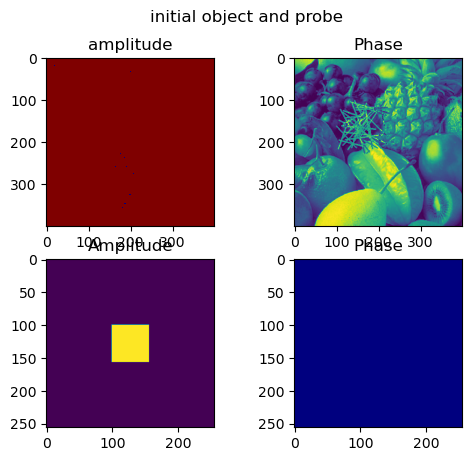

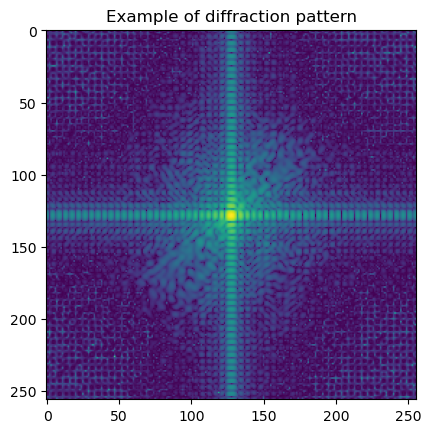

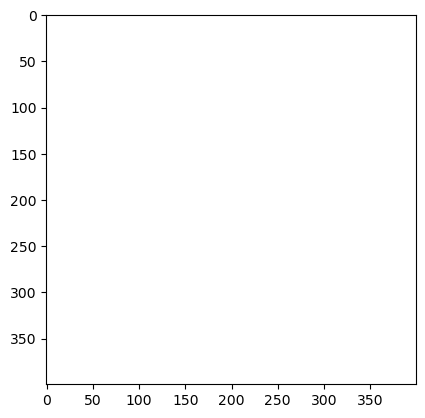

Error of last frame 5.196815537859252e+28


Text(0.5, 1.0, 'Phase probe')

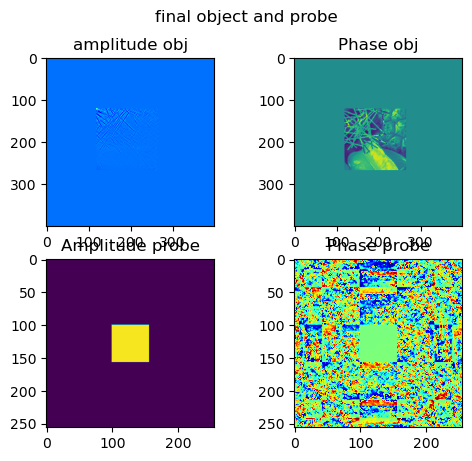

In [52]:
# %load ePIE_recon_simulation/run_ePIE_sim.py
"""
Created on 2020 01 28 try to get a ePIE simulation to work... with my old code

Working!

Loads an image. Saves image as object phase. Creates a flat field probe.
Defines scanning postions on the object. 
Creates an exit wave Y= object * probe in each scanning positions. Propagates 
the exit wave with a fft. Reconstructs the objec and probe by 
running the ePIE algorithm.

@author: Susanna Hammarberg

"""


import sys   #to collect system path ( to collect function from another directory)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numpy import fft
import numpy as np
from ePIE_recon_simulation.ePIE_engine import ePIE  


#----------------------------------
# create sim probe and object.
# load image and set to object phase or amplitude values
#----------------------------------

def image():
    
    #probe = mpimg.imread('circle.png')
    probe = np.zeros((256,256))
    #probe = np.ones((128,128))
    #probe[110:147, 110:147] = 1
    probe[100:157, 100:157] = 1
    
    obj = np.array(mpimg.imread('ePIE_recon_simulation/fruit.jpg'))
    obj[100:228, 100:228, :] += (dilated[..., None].astype('uint8') * 150)

    return probe,obj

probe, obj = image()


# collapse to 3d matrix
try:
    probe = np.array(np.sum(probe, axis=2))
except Exception:
    print('probe not 3d. OK')
try:
    obj = np.array(np.sum(obj, axis=2))
except Exception:
    print('obj not 3d. OK')


# pad image and make them complex 
padding = 0
probe = np.pad(probe, ((padding,padding),(padding,padding)), 'constant', constant_values=(0, 0))
obj = np.pad(obj, ((padding,padding),(padding,padding)), 'constant', constant_values=(0, 0))

# normalize amplitude to 1
obj = obj /obj.max()


#make object only phase (intstead of only amplitude)
#(comment out for amplitude object)
obj = 1.0 * np.exp(obj*1j) 


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, gridspec_kw={'wspace': 0}); plt.suptitle('initial object and probe'); 
ax1.imshow((np.abs(obj)),cmap='jet'); ax1.set_title('amplitude');  ax2.imshow(np.angle(obj)); ax2.set_title('Phase')
ax3.imshow(abs(probe)); ax3.set_title('Amplitude'); ax4.imshow(np.angle(probe),cmap='jet'); ax4.set_title('Phase')

#%%
#------------------------------------------------
#define scanning positions in terms of pixels
#------------------------------------------------

origin = 20
Ny = 10 ; Nx = 10
# overlapp shild be 60% stepsize = int(probeSize * 0.4)   #for 60% overlapp
dy = 10 ; dx = dy #same
positions = np.zeros((Ny*Nx,2),dtype=np.int32)
#y positions in 1st colum
positions[:, 1] = np.tile(np.arange(Nx)*dx, Ny)
#y positions in 1st colum
positions[:, 0] = np.repeat(np.arange(Ny)*dy , Nx)  
positions += origin

print('Scanning positions defined')

#----------------------------------
# make a set of diffraction patters  
#----------------------------------

# a list of diffrac tion patterns
diff_set = []
# the indices for the area that is illuminated by the probe (should have the probes shape)
illu_indy, illu_indx = np.indices((probe.shape) )

# create a diffraction pattern at each probe position
for pos in positions:   
    # Propogate (obj*probe) to far field with a Fourier transform, then calculate the absolute square
    diff_set.append(abs(fft.fftshift(fft.fft2( obj[pos[0]+illu_indy, pos[1]+illu_indx]*probe)))**2 )
  

print('Diffraction patterns created')
plt.figure();plt.title('Example of diffraction pattern')
plt.imshow(abs(np.log10(diff_set[-1])))    
#----------------------------------
# Run reconstruction
#----------------------------------

#define object shape (needed  for ePIE function)
object_shape = obj.shape   # ex (34,34)

# number of iterations in ePIE
k = 3
# run the algoritm
objectFunc, probe_ret, err = ePIE(k,diff_set,probe,object_shape, positions,illu_indy,illu_indx) 
print('Error of last frame',err)

#----------------------------------
# image the result
#----------------------------------

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, gridspec_kw={'wspace': 0}); plt.suptitle('final object and probe'); 
ax1.imshow((np.abs(objectFunc)),cmap='jet'); ax1.set_title('amplitude obj');  ax2.imshow(np.angle(objectFunc)); ax2.set_title('Phase obj')
ax3.imshow(abs(probe_ret)); ax3.set_title('Amplitude probe'); ax4.imshow(np.angle(probe_ret),cmap='jet'); ax4.set_title('Phase probe')

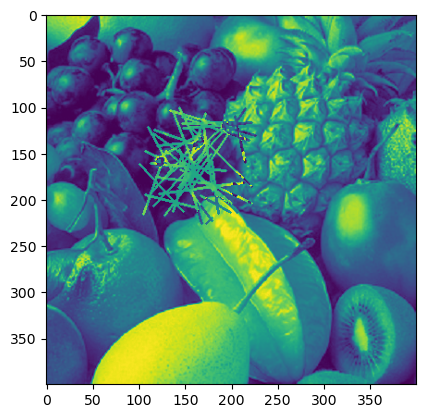

In [53]:
plt.imshow(np.angle(obj))

In [58]:
(np.angle(objectFunc)[150:200, 150:200] == np.angle(obj)[150:200, 150:200])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

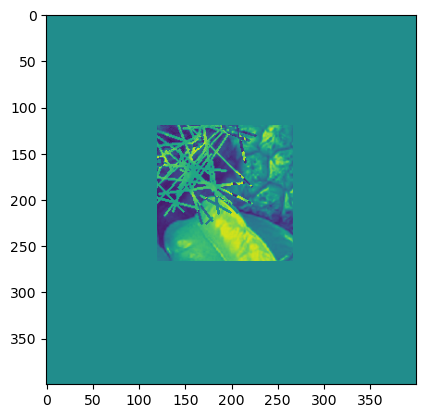

In [54]:
plt.imshow(np.angle(objectFunc))

In [50]:
dilated.astype('uint8')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [51]:
dilated

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

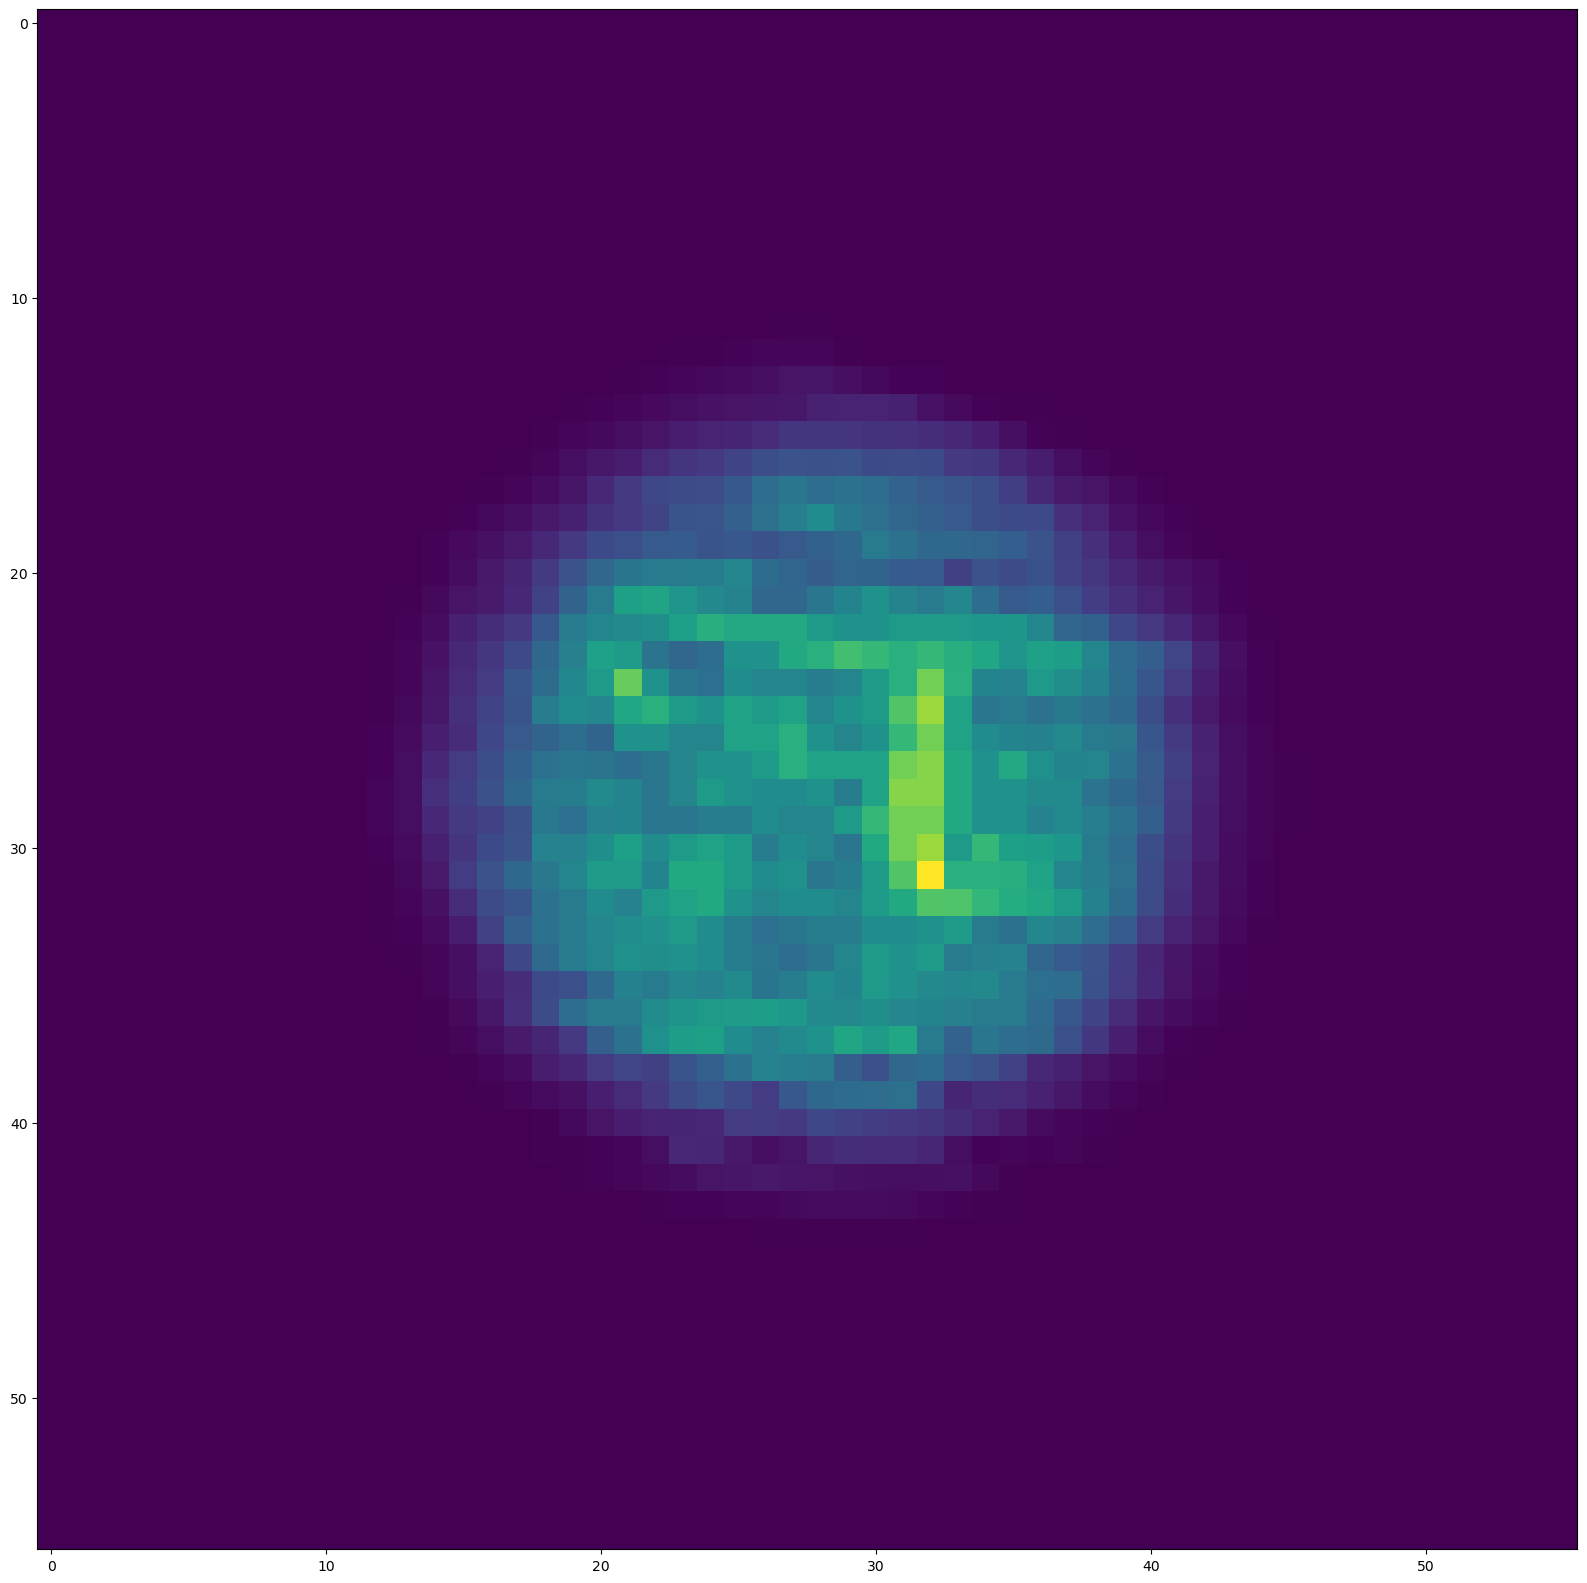

In [72]:
plt.imshow(np.squeeze(x_orig)[9])

Input diffraction:


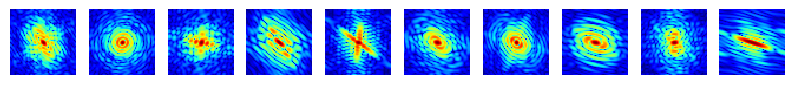

Reconstructed diffraction (modes):


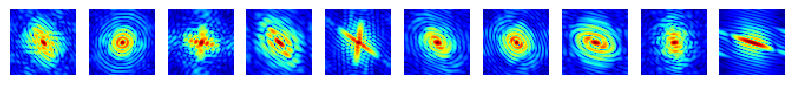

True object


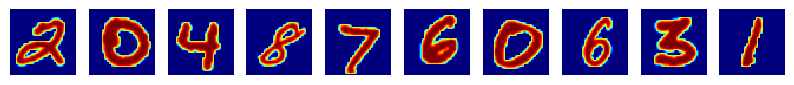

Reconstructed object (mode)


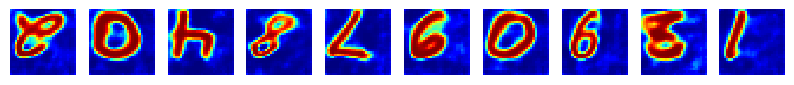

Reconstructed object variance


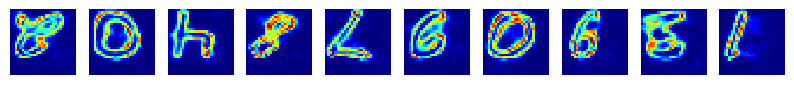

Reconstructed diffraction variance


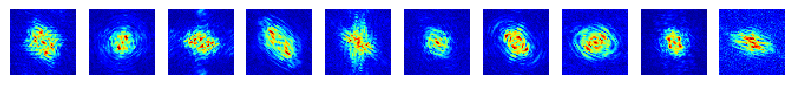

0.013367399062030159

In [112]:
x_orig = next(iter(eval_dataset))[2][:10]

# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]

# x_orig = next(iter(eval_dataset))[2][10:20]

# # We'll just examine ten random digits.
# x = next(iter(eval_dataset))[0][10:20]

xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] =(20, 20)

print('Input diffraction:')
display_imgs(x)

# print('Decoded Random Samples (top: reconstruction; bottom: diffraction):')
# tmp = decoder(encoder(x))
# display_imgs(tmp)
# display_imgs(decoder2(tmp).sample())

print('Reconstructed diffraction (modes):')
display_imgs(xhat.mode())

# print('Decoded Means:')
# display_imgs(xhat.mean())

print("True object")
display_imgs((x_orig))

print("Reconstructed object (mode)")
display_imgs((decoder(encoder(x).mode())))

print('Reconstructed object variance')
tmp = tf.stack([decoder(encoder(x)) for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))

print('Reconstructed diffraction variance')
tmp = tf.stack([vae(x).sample() for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))


# display_imgs(tf.abs(decoder(encoder(x).mode()) - resize(x_orig)))

np.percentile(np.array(tmp).std(axis = 0).ravel(), 99.9)



Randomly Generated Samples:


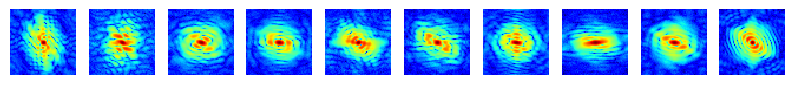

Randomly Generated Modes:


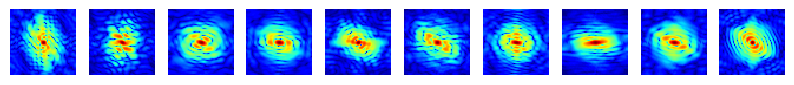

Randomly Generated Means:


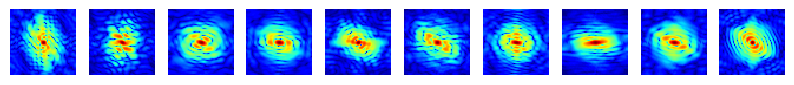

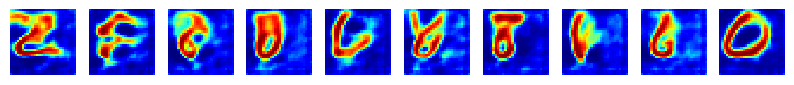

In [119]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder2(decoder(z))
assert isinstance(xtilde, tfd.Distribution)

print('Randomly Generated Samples:')
samp = xtilde.sample()
display_imgs(samp)

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

display_imgs((decoder(z)))

#display_imgs((decoder(encoder(samp))))

Illuminated object
1/1 [==============================] - 0s 38ms/step


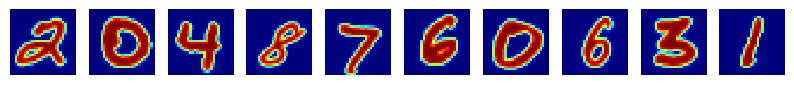

In [113]:
print("Illuminated object")
display_imgs(resize((x_orig) * 
                    tf.convert_to_tensor(probe, dtype= 'float')[:, :, None]
                   )
            )

Input diffraction:


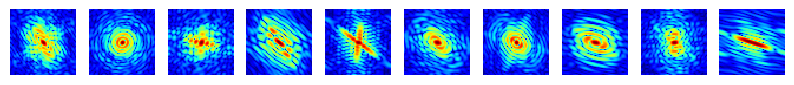

Reconstructed diffraction (modes):


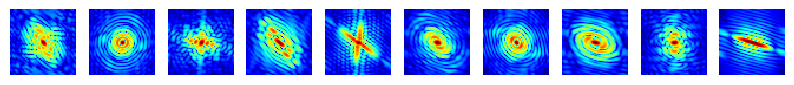

True object


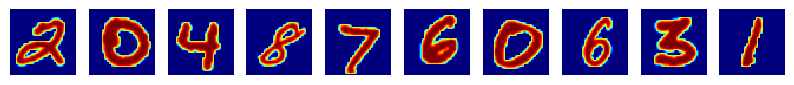

Reconstructed object (mode)


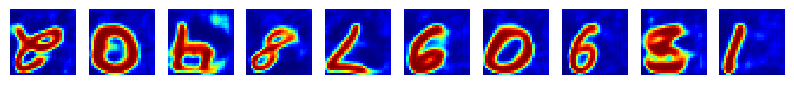

Reconstructed object variance


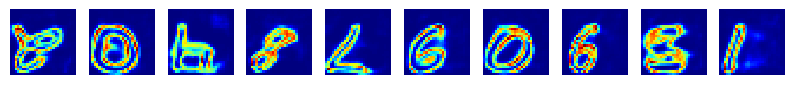

Reconstructed diffraction variance


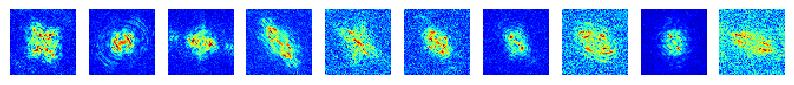

0.009230946562252979

In [222]:
x_orig = next(iter(eval_dataset))[2][:10]

# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]

# x_orig = next(iter(eval_dataset))[2][10:20]

# # We'll just examine ten random digits.
# x = next(iter(eval_dataset))[0][10:20]

xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] =(20, 20)

print('Input diffraction:')
display_imgs(x)

# print('Decoded Random Samples (top: reconstruction; bottom: diffraction):')
# tmp = decoder(encoder(x))
# display_imgs(tmp)
# display_imgs(decoder2(tmp).sample())

print('Reconstructed diffraction (modes):')
display_imgs(xhat.mode())

# print('Decoded Means:')
# display_imgs(xhat.mean())

print("True object")
display_imgs((x_orig))

print("Reconstructed object (mode)")
display_imgs((decoder(encoder(x).mode())))

print('Reconstructed object variance')
tmp = tf.stack([decoder(encoder(x)) for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))

print('Reconstructed diffraction variance')
tmp = tf.stack([vae(x).sample() for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))


# display_imgs(tf.abs(decoder(encoder(x).mode()) - resize(x_orig)))

np.percentile(np.array(tmp).std(axis = 0).ravel(), 99.9)



In [230]:
np.array(tmp).mean(axis = 0).mean(axis = 3).mean(axis = 2).mean(axis = 1)

array([0.04129243, 0.04187356, 0.03157837, 0.03132818, 0.03076614,
       0.03673065, 0.03975851, 0.03492882, 0.03467346, 0.02339565],
      dtype=float32)

In [248]:
x[..., None].shape

TensorShape([10, 56, 56, 1])

In [249]:
resize(x).shape

1/1 [==============================] - 0s 27ms/step


(10, 28, 28, 1)

Illuminated object
1/1 [==============================] - 0s 20ms/step


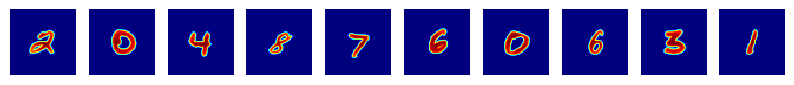

In [71]:
print("Illuminated object")
display_imgs(resize((x_orig) * 
                    tf.convert_to_tensor(probe, dtype= 'float')[:, :, None]
                   )
            )

Diffraction:


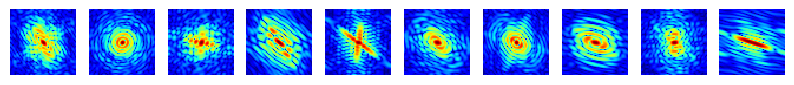

Decoded Random Samples:


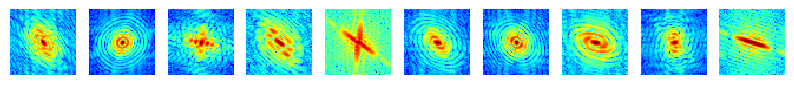

Decoded Modes:


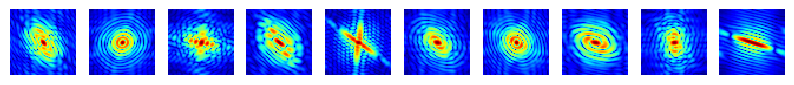

Decoded Means:


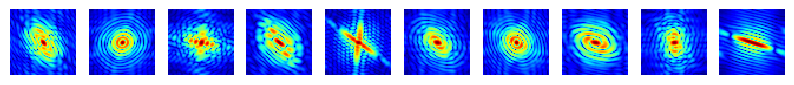

True object
1/1 [==============================] - 0s 20ms/step


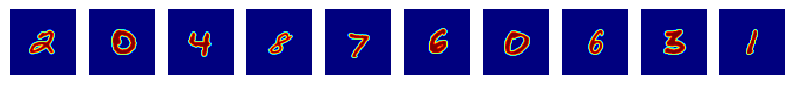

Reconstructed object
1/1 [==============================] - 0s 20ms/step


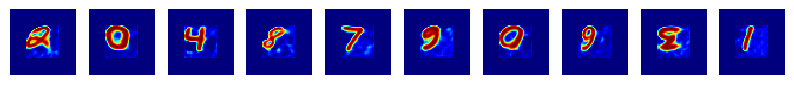

Variance


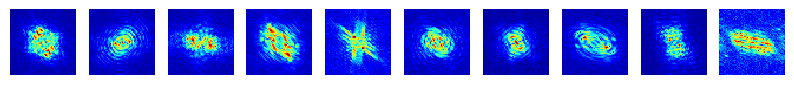

0.0034961721

In [436]:
x_orig = next(iter(eval_dataset))[2][:10]

# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] =(20, 20)

print('Diffraction:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

print("True object")
display_imgs(resize(x_orig))

print("Reconstructed object")
display_imgs(resize(decoder(encoder(x).mode())))

print('Variance')
tmp = tf.stack([vae(x).sample() for _ in range(100)])
display_imgs((np.array(tmp).std(axis = 0)))
np.array(tmp).std(axis = 0).mean()

Illuminated object
1/1 [==============================] - 0s 21ms/step


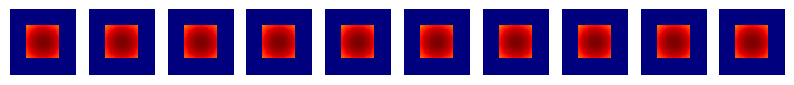

In [434]:
print("Illuminated object")
display_imgs(resize(tf.ones_like(x_orig) * 
                    tf.convert_to_tensor(probe, dtype= 'float')[:, :, None]
                   )
            )

In [360]:
# mkdir models/mnist_fourier_vae/

In [232]:
vae.save('models/mnist_fourier_vae/vae.h5')

encoder.save('models/mnist_fourier_vae/encoder.h5')

decoder.save('models/mnist_fourier_vae/decoder.h5')

decoder2.save('models/mnist_fourier_vae/decoder2.h5')

Randomly Generated Samples:


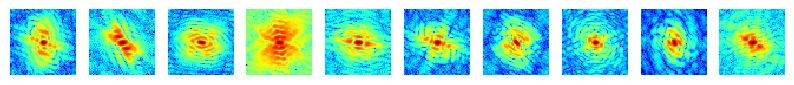

Randomly Generated Modes:


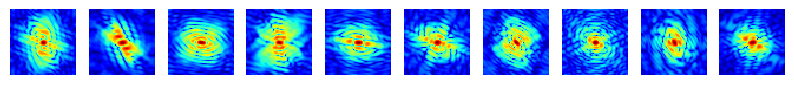

Randomly Generated Means:


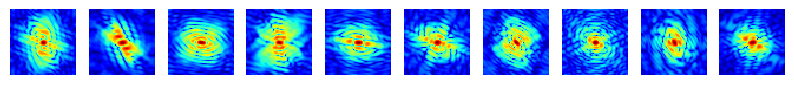

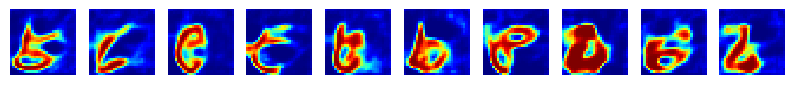

In [255]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder2(decoder(z))
assert isinstance(xtilde, tfd.Distribution)

print('Randomly Generated Samples:')
samp = xtilde.sample()
display_imgs(samp)

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

display_imgs((decoder(z)))

#display_imgs((decoder(encoder(samp))))

Randomly Generated Samples:


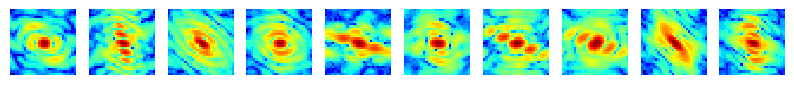

Randomly Generated Modes:


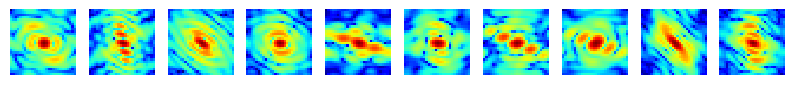

Randomly Generated Means:


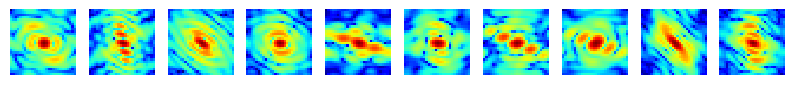

1/1 [==============================] - 0s 20ms/step


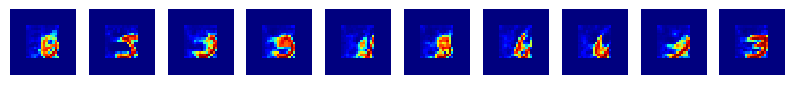

1/1 [==============================] - 0s 20ms/step


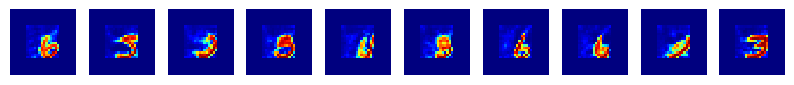

In [23]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder2(decoder(z))
assert isinstance(xtilde, tfd.Distribution)

print('Randomly Generated Samples:')
samp = xtilde.sample()
display_imgs(samp)

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

display_imgs(resize(decoder(z)))

display_imgs(resize(decoder(encoder(samp))))

Randomly Generated Samples:


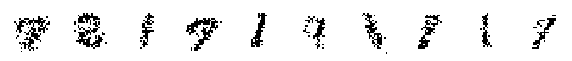

Randomly Generated Modes:


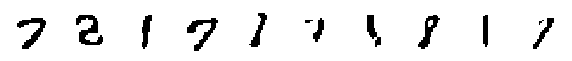

Randomly Generated Means:


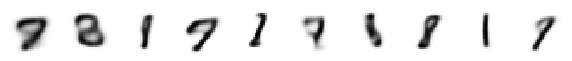

In [455]:
print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())

In [522]:
import os

import numpy as np
import torch
from pyro.contrib.examples.util import MNIST
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [523]:
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [542]:
do_forward(nn.ZeroPad2d((0, 1, 0, 1))(x)).shape

torch.Size([16, 1, 29, 29])

In [543]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.Compose([transforms.ToTensor(),
                                nn.ZeroPad2d((0, 1, 0, 1)),
                                do_forward])
    train_set = MNIST(root=root, train=True, transform=trans,
                      download=download)
    test_set = MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [544]:
import torchvision

In [586]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, N**2)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()
        self.z_dim = z_dim
        
#         base_depth = 32
        
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(1, 2 * base_depth, 7, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(2 * base_depth),
            nn.LeakyReLU()
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(2 * base_depth, 2 * base_depth, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(2 * base_depth),
            nn.LeakyReLU())
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(2 * base_depth, 2 * base_depth, kernel_size=5, stride=2, padding='same'),
            nn.BatchNorm2d(2 * base_depth),
            nn.LeakyReLU()
        )
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(2 * base_depth, base_depth, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(base_depth),
            nn.LeakyReLU())
        
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(base_depth, base_depth, kernel_size=5, stride=2, padding='same'),
            nn.BatchNorm2d(base_depth),
            nn.LeakyReLU())
        
        self.layer6 = nn.Sequential(
            nn.ConvTranspose2d(base_depth, base_depth, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(base_depth),
            nn.LeakyReLU())
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(base_depth, 1, kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(base_depth)  
    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output distribution
        # each is of size batch_size x (flattened data size)
        loc_img = self.sigmoid(self.fc21(hidden)).reshape(-1, N, N)
        blur = torchvision.transforms.GaussianBlur(5, sigma=(.8, .8))

        return blur(loc_img)

In [587]:
import torch.nn.functional as F

In [588]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim = 7*7*16):
        super().__init__()
        
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #self.fc1 = nn.Linear(7*7*32, hidden_dim)

#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, base_depth, kernel_size=5, stride=1, padding='same'),
#             nn.BatchNorm2d(base_depth),
#             nn.LeakyReLU()
#         )
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(base_depth, base_depth, kernel_size=5, stride=2, padding='same'),
#             nn.BatchNorm2d(base_depth),
#             nn.LeakyReLU())
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(base_depth, 2 * base_depth, kernel_size=5, stride=1, padding='same'),
#             nn.BatchNorm2d(2 * base_depth),
#             nn.LeakyReLU()
#         )
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(2 * base_depth, 2 * base_depth, kernel_size=5, stride=2, padding='same'),
#             nn.BatchNorm2d(2 * base_depth),
#             nn.LeakyReLU())
        
        
        
        # setup the three linear transformations used
        #self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x


        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        #hidden = self.softplus(self.fc1(out))
        hidden = self.softplus(out)

#         # first shape the mini-batch to have pixels in the rightmost dimension
#         x = x.reshape(-1, 784)
        # then compute the hidden units
        #hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [589]:
obs_sigma = .05

In [591]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=7*7*16, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        #x = do_forward(x)
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z

            loc_img = do_forward(
                    self.decoder(z)
                ).reshape(-1, N**2)
            # score against actual images
            #pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))
            return pyro.sample("obs", dist.Normal(loc_img, obs_sigma).to_event(1),
                               obs=x.reshape(-1, N**2))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        #x = do_forward(x)
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [592]:
do_forward(x[10]).max()

tensor(0.4922)

In [593]:
vae = VAE()

In [594]:
optimizer = Adam({"lr": 1.0e-3})

In [595]:
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [596]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [597]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test